In [1]:
import pandas as pd
import numpy as np

# Display the full output in this notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
!pip install torch
!pip install transformers
import ast


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

  Using cached torch-1.11.0-cp38-cp38-manylinux1_x86_64.whl (750.6 MB)

         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
          

In [3]:
df = pd.read_csv("/project/question-answers-processed/fin-ba-processed-combined.csv")

In [4]:
df.head(3)

,Unnamed: 0,question,answers,context_file,answer_start,answer_end,context
0,0,What is the fee for Business Analytics?,"UK - £19,400, and Overseas - £35,100",corpus/business-analytics/1.txt,63.0,99.0,Start date: September 2022 Duration: 12 months...
1,1,What is the fee for MSc of Business Analytics?,"UK - £19,400, and Overseas - £35,100",corpus/business-analytics/1.txt,63.0,99.0,Start date: September 2022 Duration: 12 months...
2,2,What's the masters fee for business analytics?,"UK - £19,400, and Overseas - £35,100",corpus/business-analytics/1.txt,63.0,99.0,Start date: September 2022 Duration: 12 months...


In [5]:
from sklearn.model_selection import train_test_split

df_train, df_dev = train_test_split(df, test_size=0.2, random_state=42)

# Split df_dev into a validation and test set
df_dev, df_test = df_dev[:205], df_dev[205:]

In [6]:
len(df_train)
len(df_dev)
len(df_test)

1633

205

204

In [7]:
from transformers import BertForQuestionAnswering, AutoTokenizer

model_name = 'deepset/bert-base-cased-squad2'


model = BertForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
train = tokenizer(list(df_train["context"]), list(df_train["question"]),
                  truncation=True, padding='max_length',
                  max_length=512, return_tensors='pt')

val = tokenizer(list(df_dev["context"]), list(df_dev["question"]),
                  truncation=True, padding='max_length',
                  max_length=512, return_tensors='pt')

In [9]:
from tqdm.auto import tqdm  # for showing progress bar

In [10]:
tokenizer.decode(train['input_ids'][0])
tokenizer.decode(val['input_ids'][0])

'[CLS] MSc Finance students are expected to have basic knowledge in financial mathematics and econometrics, and should be motivated to take their knowledge to the next level. To get to that next level, we expect a great deal from our students, so if you choose to study with us, you can expect to be working hard, challenging yourself as we challenge you, and regularly finding yourself out of your comfort zone. [SEP] Are relevant work experiences required to be eligible for admission for the master program in Finance? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

'[CLS] MSc Finance students are expected to have basic knowledge in financial mathematics and econometrics, and should be motivated to take their knowledge to the next level. To get to that next level, we expect a great deal from our students, so if you choose to study with us, you can expect to be working hard, challenging yourself as we challenge you, and regularly finding yourself out of your comfort zone. [SEP] Do I need basic finance knowledge for the Finance master? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [11]:
df_train = df_train.astype({"answer_start": int, "answer_end": int})
df_dev = df_dev.astype({"answer_start": int, "answer_end": int})

In [12]:
train_start_pos = df_train['answer_start'].tolist()
train_end_pos = df_train['answer_end'].tolist()
val_start_pos = df_dev['answer_start'].tolist()
val_end_pos = df_dev['answer_end'].tolist()

In [13]:
# Import the start_position & end_position to the dict
train.update({'start_positions': train_start_pos, 'end_positions': train_end_pos})
val.update({'start_positions': val_start_pos, 'end_positions': val_end_pos})

In [14]:
# Check the keys in the dict
train.keys()
val.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])

In [15]:
# Train the model using Pytorch
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

# build datasets for both our training data
train_dataset = SquadDataset(train)
val_dataset = SquadDataset(val)

In [16]:
# Feed our train dataset

batch_size=16
train_loader = torch.utils.data.DataLoader(train_dataset,
                                     batch_size=batch_size,
                                     shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                     batch_size=batch_size,
                                     shuffle=True)

In [17]:
from transformers import AdamW

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
model.to(device)
#model.train()
#criterion = torch.nn.BCELoss()  # binary cross-entropy loss
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [18]:
!pip install PyPrind
import pyprind


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

  Using cached PyPrind-2.11.3-py2.py3-none-any.whl (8.4 kB)


In [19]:
def train(model, train_loader, optimizer):
    epoch_loss = 0
    #epoch_acc = 0
    
    model.train()
    bar = pyprind.ProgBar(len(train_loader), bar_char='█')
    for batch in train_loader:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, 
                        start_positions=start_positions,
                        end_positions=end_positions)
        
        loss = outputs[0]
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        #epoch_acc += acc
        bar.update()
    return epoch_loss / len(train_loader)#, epoch_acc / len(train_loader)

In [20]:
def evaluate(model, val_loader):
    epoch_loss = 0
    
    model.eval()
    with torch.no_grad():
        bar = pyprind.ProgBar(len(val_loader), bar_char='█')
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)
        
            outputs = model(input_ids, attention_mask=attention_mask, 
                        start_positions=start_positions,
                        end_positions=end_positions)
            
            loss = outputs[0]

            epoch_loss += loss.item()
            bar.update()
    return epoch_loss / len(val_loader)

In [21]:
# Train the model
N_EPOCHS = 4
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer)
    valid_loss = evaluate(model, val_loader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')

<ipython-input-15-aca00554063a>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:14:07
0% [█████████████] 100% | ETA: 00:00:00

Epoch: 01 | Train Loss: 2.743 | Val. Loss: 0.880



Total time elapsed: 00:00:27
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:14:20
0% [█████████████] 100% | ETA: 00:00:00

Epoch: 02 | Train Loss: nan | Val. Loss: 0.361



Total time elapsed: 00:00:27
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:14:07
0% [█████████████] 100% | ETA: 00:00:00

Epoch: 03 | Train Loss: 0.294 | Val. Loss: 0.284



Total time elapsed: 00:00:27
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:13:59
0% [█████████████] 100% | ETA: 00:00:00

Epoch: 04 | Train Loss: 0.184 | Val. Loss: 0.214



Total time elapsed: 00:00:27


In [22]:
# for epoch in range(8):
#     loop = tqdm(loader)
    
    
#     for batch in loop:
#         optim.zero_grad()

#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         start_positions = batch['start_positions'].to(device)
#         end_positions = batch['end_positions'].to(device)
# #         print('inputid', input_ids)
# #         print('inputid', input_ids.shape)
# #         print('attnm', attention_mask)
# #         print('startpos', start_positions)
# #         print('startpos', end_positions)

#         outputs = model(input_ids, attention_mask=attention_mask, 
#                         start_positions=start_positions,
#                         end_positions=end_positions)
        
#         loss = outputs[0]
#         loss.sum().backward()
#         optim.step()

#         loop.set_description(f'Epoch {epoch}')
#         loop.set_postfix(loss=loss.sum().item())

## Testing on the dev model

In [23]:
from transformers import pipeline
nlp = pipeline('question-answering', model=model, tokenizer=tokenizer)

In [24]:
df_dev['question'].values[0]

'Do I need basic finance knowledge for the Finance master?'

In [25]:
df_dev.reset_index(drop=True, inplace=True)

In [38]:
df_test.reset_index(drop=True, inplace=True)

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

nlp('how are u', 'I am good today')

{'score': 0.01514357514679432, 'start': 5, 'end': 9, 'answer': 'good'}

In [27]:
nlp(df_dev.loc[1]['question'], df_dev.loc[1]['context'])['score']

1.2361620349565783e-07

In [28]:
df_dev

,Unnamed: 0,question,answers,context_file,answer_start,answer_end,context
0,1316,Do I need basic finance knowledge for the Fina...,MSc Finance students are expected to have basi...,corpus/finance/26.txt,0,167,MSc Finance students are expected to have basi...
1,1000,"For MSc Finance, what is the structure of the ...",All participants study four core modules in Te...,corpus/finance/3.txt,0,644,All participants study four core modules in Te...
2,1068,What is the requirement for GMAR or GRE exam f...,We do not require GMAT/GRE scores,corpus/finance/52.txt,378,411,Qualifications which are requested to support ...
3,1969,"For the master program in Finance, who should ...",the Programme Administrator via email at: mgmt...,corpus/finance/54.txt,76,140,For further information regarding the MSc Fina...
4,529,What information do I need to provide for my M...,You will need to include a degree transcript i...,corpus/business-analytics/105.txt,0,232,You will need to include a degree transcript i...
...,...,...,...,...,...,...,...
200,367,Is there a contact email for potential candita...,the Programme Administrator via: mgmt-ba@ucl.a...,corpus/business-analytics/73.txt,76,126,For further information regarding the Business...
201,757,Does my bachelor degree has to be highly numer...,we stress to our applicants that this programm...,corpus/finance/28.txt,84,227,While we do welcome students from a wide varie...
202,1985,What is the structure of the program for the m...,All participants study four core modules in Te...,corpus/finance/3.txt,0,644,All participants study four core modules in Te...
203,1582,"For the master program in Finance, what is the...","UK/EU/Overseas - £38,000",corpus/finance/1.txt,63,87,Start date: September 2022 Duration: 12 months...


In [29]:
result_df = pd.DataFrame(columns=['question', 'answer', 'model_answer', 'confidence_score', 'start_index', 'end_index'])

for i in range(df_dev.shape[0]):
    output = nlp(df_dev['question'].values[i], df_dev['context'].values[i])
    output_df = pd.DataFrame({'question': df_dev['question'].values[i], 'answer': df_dev['answers'].values[i],'model_answer': output['answer'], 'confidence_score': output['score'], 'start_index':output['start'], 'end_index':output['end']}, index=[i])
    
    result_df = pd.concat([result_df, output_df])

In [39]:
result_df_test = pd.DataFrame(columns=['question', 'answer', 'model_answer', 'confidence_score', 'start_index', 'end_index'])

for i in range(df_test.shape[0]):
    output = nlp(df_test['question'].values[i], df_test['context'].values[i])
    output_df = pd.DataFrame({'question': df_test['question'].values[i], 'answer': df_test['answers'].values[i],'model_answer': output['answer'], 'confidence_score': output['score'], 'start_index':output['start'], 'end_index':output['end']}, index=[i])
    
    result_df = pd.concat([result_df_test, output_df])

In [30]:
result_df.to_csv('dev-set-verification/bert-base-v0.csv')

result_df

FileNotFoundError: [Errno 2] No such file or directory: 'dev-set-verification/bert-base-v0.csv'

In [31]:
result_df['comparison'] = np.where(result_df['answer'] == result_df['model_answer'] , 'True', 'False')

result_df

,question,answer,model_answer,confidence_score,start_index,end_index,comparison
0,Do I need basic finance knowledge for the Fina...,MSc Finance students are expected to have basi...,basic knowledge in financial mathematics and e...,3.635168e-05,42,100,False
1,"For MSc Finance, what is the structure of the ...",All participants study four core modules in Te...,.,1.236162e-07,432,433,False
2,What is the requirement for GMAR or GRE exam f...,We do not require GMAT/GRE scores,GMAT/GRE scores -,5.164768e-05,396,413,False
3,"For the master program in Finance, who should ...",the Programme Administrator via email at: mgmt...,the UCL Postgraduate Admissions Website,1.277545e-03,213,252,False
4,What information do I need to provide for my M...,You will need to include a degree transcript i...,personal statement,7.101690e-07,104,122,False
...,...,...,...,...,...,...,...
200,Is there a contact email for potential candita...,the Programme Administrator via: mgmt-ba@ucl.a...,mgmt-ba,3.095100e-03,109,116,False
201,Does my bachelor degree has to be highly numer...,we stress to our applicants that this programm...,prepare for.,1.421838e-02,442,454,False
202,What is the structure of the program for the m...,All participants study four core modules in Te...,.,9.675361e-08,331,332,False
203,"For the master program in Finance, what is the...","UK/EU/Overseas - £38,000",Minimum of 2:1 or equivalent in a relevant dis...,1.365407e-04,254,307,False


In [32]:
result_df.comparison.value_counts()

False    204
True       1
Name: comparison, dtype: int64

In [33]:
import collections

# get tokens from text; just by splitting by spces
def get_simple_tokens(text):
    tokens = [token.strip() for token in text.split()]
    
    return tokens

# calculate f1 score for a single prediction-answer pair
def get_f1(pred, answer):
    pred_tokens = get_simple_tokens(pred)
    ans_tokens = get_simple_tokens(answer)
    
    common_tokens = collections.Counter(pred_tokens) & collections.Counter(ans_tokens)
    common_tokens_n = sum(common_tokens.values())
    
    if common_tokens_n == 0:
        return 0
    
    precision = 1.0 * common_tokens_n/len(pred_tokens)
    recall = 1.0 * common_tokens_n/len(ans_tokens)
    
    f1 = 2*((precision*recall)/(precision+recall))
    
    return f1

In [34]:
# loop through all answers, for df use for i in range(result_df.shape[0])

f1_scores = []
for i in range(result_df.shape[0]):
    f1_scores.append(get_f1(result_df['model_answer'].values[i], result_df['answer'].values[i]))
    
result_df['f1_score'] = f1_scores

In [35]:
result_df['f1_score'].mean()

0.2303012514052194

In [40]:
# loop through all answers, for df use for i in range(result_df.shape[0])

f1_scores_test = []
for i in range(result_df_test.shape[0]):
    f1_scores_test.append(get_f1(result_df_test['model_answer'].values[i], result_df_test['answer'].values[i]))
    
result_df_test['f1_score'] = f1_scores_test

In [41]:
result_df_test['f1_score'].mean()

nan

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 0, 'Epoch #')

Text(0, 0.5, 'Binary Cross-Entropy Loss')

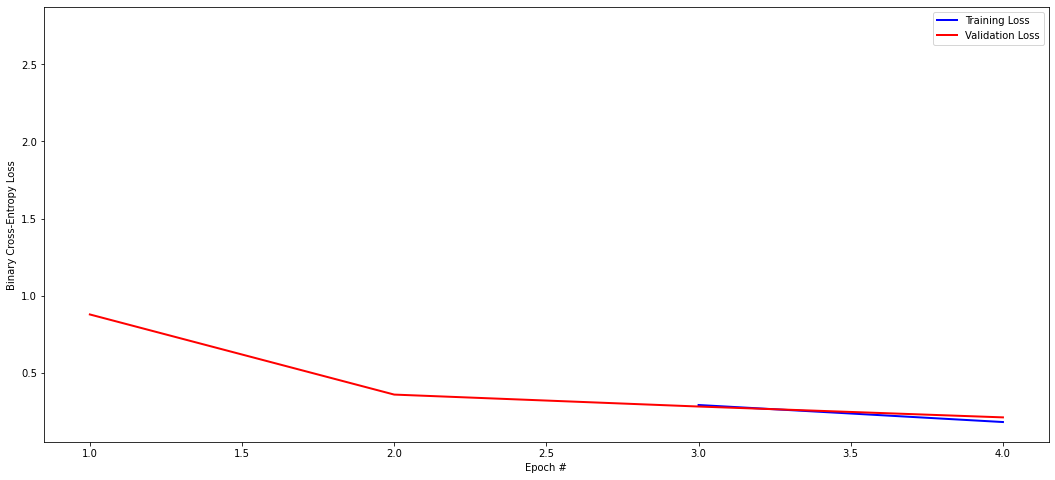

In [37]:
# Plot the training and validation losses
fig = plt.figure(figsize=(18, 8))
x = list(range(1, 1+len(train_losses)))

plt.plot(x, train_losses, 'b', linewidth=2)
plt.plot(x, valid_losses, 'r', linewidth=2)
plt.xlabel('Epoch #')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend(('Training Loss', 'Validation Loss'))
plt.show()